# GPT-2 Research Paper | Part I

## The Deep Dive: Everything You Didn't Know About GPT-2

---

**Paper:** [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

**Authors:** Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei, Ilya Sutskever (OpenAI, 2019)

---

## Beyond the Headlines

Everyone knows GPT-2 was "too dangerous to release." But the real story is far more fascinating.

This notebook reveals:
- **The hidden hypothesis** that drove the entire project
- **WebText's secret sauce** - exactly how Reddit karma became AI training data
- **The byte-level BPE trick** that solved the "unknown token" problem forever
- **Why zero-shot works** - the mathematical intuition nobody explains
- **The scaling revelation** that changed AI research forever
- **Internal OpenAI debates** about the release
- **Emergent abilities** they didn't expect to find

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, FancyArrowPatch, Wedge, Arc
from matplotlib.patches import ConnectionPatch, Polygon, Ellipse, PathPatch
from matplotlib.path import Path
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10

torch.manual_seed(42)
np.random.seed(42)

print("Ready to explore the secrets of GPT-2!")

Ready to explore the secrets of GPT-2!


---

## 1. The Hidden Hypothesis: "Competent Generalists"

### 1.1 What Everyone Thinks GPT-2 Is About

Most people think GPT-2 was just "bigger GPT-1." **Wrong.**

GPT-2 was an **experiment to test a radical hypothesis**:

> *"Current systems are better characterized as narrow experts rather than competent generalists. We would like to move towards more general systems which can perform many tasks – eventually without the need to manually create and label a training dataset for each one."*

### 1.2 The Real Question They Were Asking

The paper asks a profound question that most readers miss:

> *"Since the supervised objective is the the same as the unsupervised objective but only evaluated on a subset of the sequence, the global minimum of the unsupervised objective is also the global minimum of the supervised objective."*

**Translation:** If you're good enough at predicting the next word, you must understand EVERYTHING about language - including how to do any task.

### 1.3 The Mathematical Insight Nobody Talks About

The paper makes a claim that most readers skip over:

$$p(\text{output} | \text{input}) = p(\text{output} | \text{input}, \text{task})$$

When the task is **implicit in natural language**, a language model learns:

$$p(\text{output} | \text{input}, \text{task}) \approx p(\text{next tokens} | \text{context})$$

This is **not obvious**. It's saying that "understanding language" and "understanding tasks" are the **same thing**.

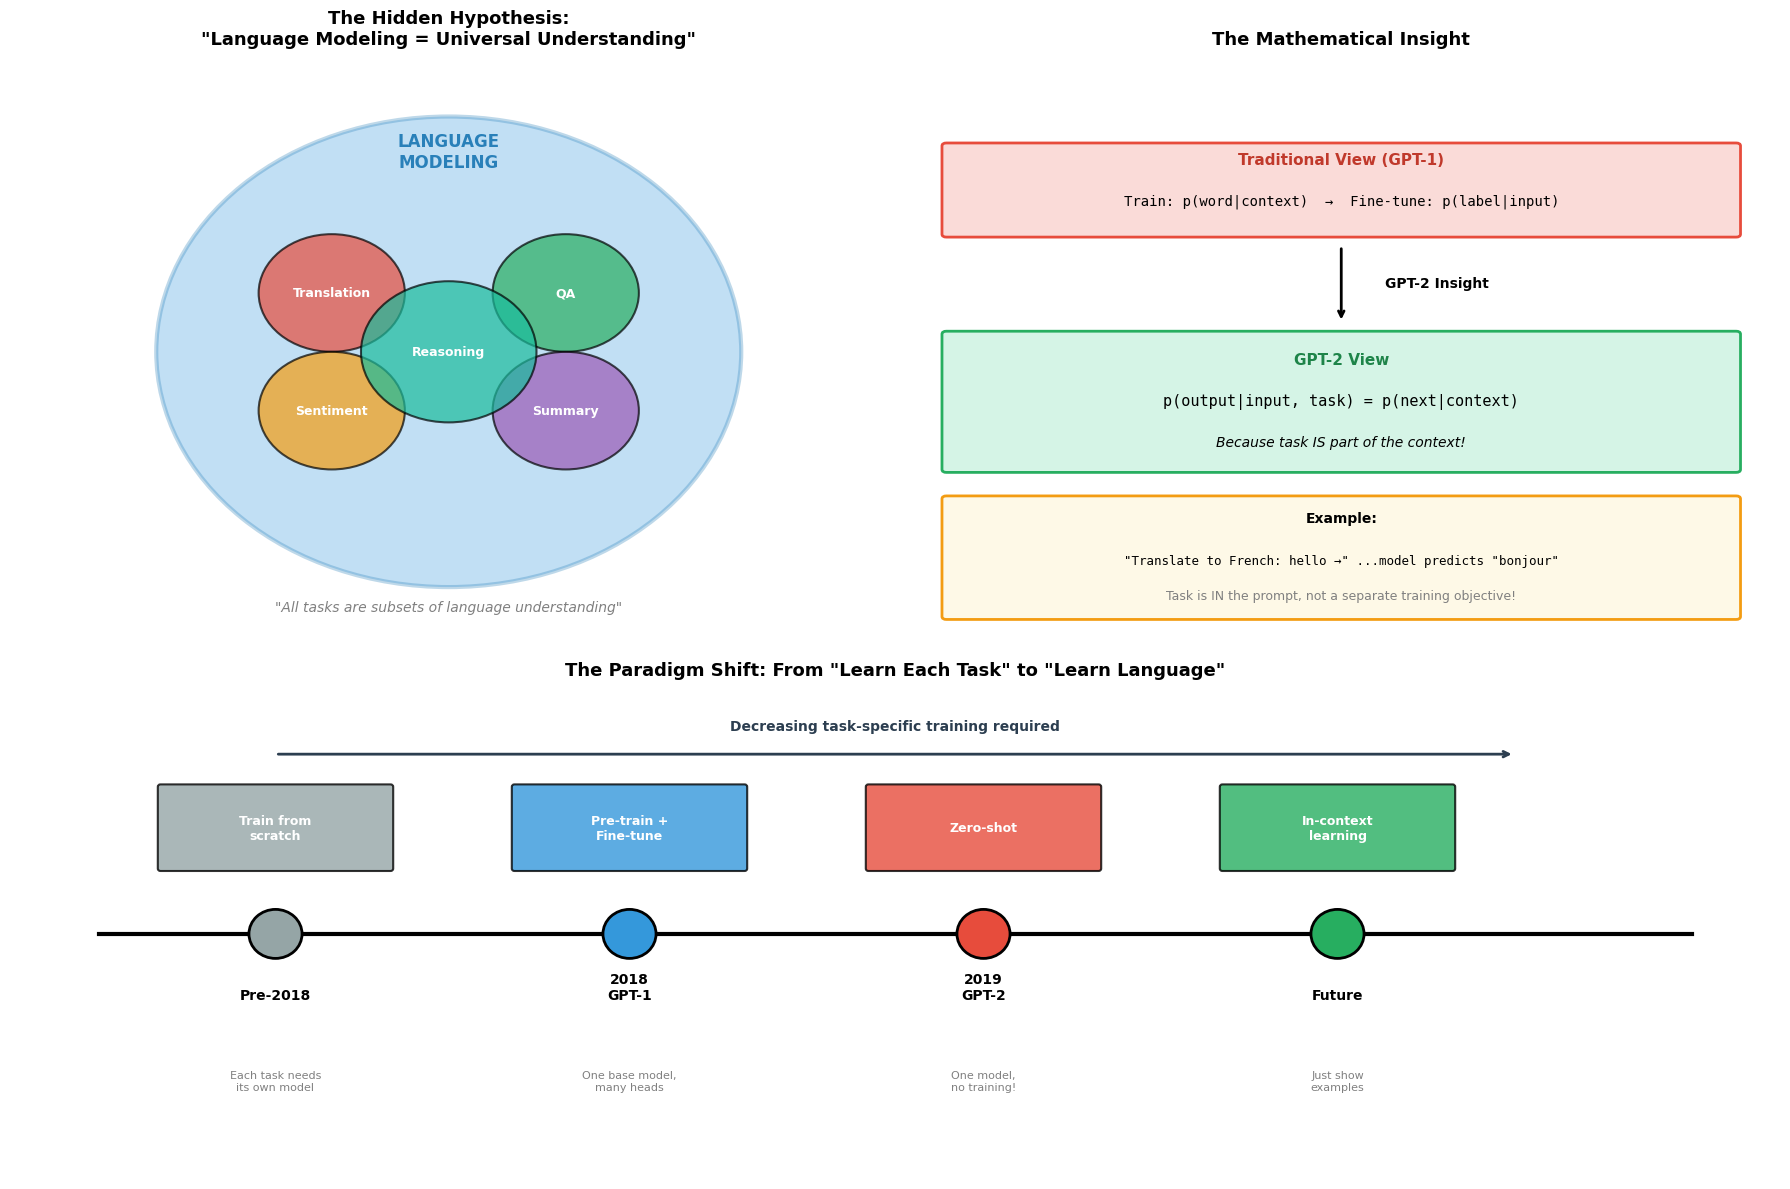

In [2]:
def visualize_the_hidden_hypothesis():
    """
    Visualize the core hypothesis: Language modeling subsumes all NLP tasks.
    """
    fig = plt.figure(figsize=(18, 12))

    # Create a complex layout
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.2, 1], width_ratios=[1, 1])

    # === TOP LEFT: The Venn Diagram of Understanding ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-2.5, 2.5)
    ax1.axis('off')
    ax1.set_title('The Hidden Hypothesis:\n"Language Modeling = Universal Understanding"',
                  fontsize=13, fontweight='bold', pad=10)

    # Large circle: Language Understanding
    circle_main = plt.Circle((0, 0), 2, facecolor='#3498db', alpha=0.3,
                              edgecolor='#2980b9', linewidth=3)
    ax1.add_patch(circle_main)
    ax1.text(0, 1.7, 'LANGUAGE\nMODELING', ha='center', va='center',
             fontsize=12, fontweight='bold', color='#2980b9')

    # Inner circles: Different tasks (all contained within)
    tasks = [
        (-0.8, 0.5, 0.5, 'Translation', '#e74c3c'),
        (0.8, 0.5, 0.5, 'QA', '#27ae60'),
        (-0.8, -0.5, 0.5, 'Sentiment', '#f39c12'),
        (0.8, -0.5, 0.5, 'Summary', '#9b59b6'),
        (0, 0, 0.6, 'Reasoning', '#1abc9c'),
    ]

    for x, y, r, name, color in tasks:
        circle = plt.Circle((x, y), r, facecolor=color, alpha=0.7,
                            edgecolor='black', linewidth=1.5)
        ax1.add_patch(circle)
        ax1.text(x, y, name, ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')

    ax1.text(0, -2.2, '"All tasks are subsets of language understanding"',
             ha='center', fontsize=10, style='italic', color='gray')

    # === TOP RIGHT: The Probability Equation ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('The Mathematical Insight', fontsize=13, fontweight='bold', pad=10)

    # Traditional view
    rect1 = FancyBboxPatch((0.5, 7), 9, 1.5, boxstyle="round,pad=0.05",
                           facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax2.add_patch(rect1)
    ax2.text(5, 8.2, 'Traditional View (GPT-1)', fontsize=11, fontweight='bold',
             ha='center', color='#c0392b')
    ax2.text(5, 7.5, 'Train: p(word|context)  →  Fine-tune: p(label|input)',
             fontsize=10, ha='center', family='monospace')

    # Arrow
    ax2.annotate('', xy=(5, 5.5), xytext=(5, 6.8),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax2.text(5.5, 6.1, 'GPT-2 Insight', fontsize=10, fontweight='bold')

    # GPT-2 view
    rect2 = FancyBboxPatch((0.5, 3), 9, 2.3, boxstyle="round,pad=0.05",
                           facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect2)
    ax2.text(5, 4.8, 'GPT-2 View', fontsize=11, fontweight='bold',
             ha='center', color='#1e8449')
    ax2.text(5, 4.1, 'p(output|input, task) = p(next|context)',
             fontsize=11, ha='center', family='monospace')
    ax2.text(5, 3.4, 'Because task IS part of the context!',
             fontsize=10, ha='center', style='italic')

    # Example
    rect3 = FancyBboxPatch((0.5, 0.5), 9, 2, boxstyle="round,pad=0.05",
                           facecolor='#fef9e7', edgecolor='#f39c12', linewidth=2)
    ax2.add_patch(rect3)
    ax2.text(5, 2.1, 'Example:', fontsize=10, fontweight='bold', ha='center')
    ax2.text(5, 1.4, '"Translate to French: hello →" ...model predicts "bonjour"',
             fontsize=9, ha='center', family='monospace')
    ax2.text(5, 0.8, 'Task is IN the prompt, not a separate training objective!',
             fontsize=9, ha='center', color='gray')

    # === BOTTOM: The Paradigm Shift Timeline ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 6)
    ax3.axis('off')
    ax3.set_title('The Paradigm Shift: From "Learn Each Task" to "Learn Language"',
                  fontsize=13, fontweight='bold', pad=10)

    # Timeline
    ax3.plot([1, 19], [3, 3], 'k-', linewidth=3)

    paradigms = [
        (3, 'Pre-2018', 'Train from\nscratch', 'Each task needs\nits own model', '#95a5a6'),
        (7, '2018\nGPT-1', 'Pre-train +\nFine-tune', 'One base model,\nmany heads', '#3498db'),
        (11, '2019\nGPT-2', 'Zero-shot', 'One model,\nno training!', '#e74c3c'),
        (15, 'Future', 'In-context\nlearning', 'Just show\nexamples', '#27ae60'),
    ]

    for x, year, method, desc, color in paradigms:
        # Marker
        circle = plt.Circle((x, 3), 0.3, facecolor=color, edgecolor='black', linewidth=2, zorder=10)
        ax3.add_patch(circle)

        # Year
        ax3.text(x, 2.2, year, ha='center', fontsize=10, fontweight='bold')

        # Method box
        rect = FancyBboxPatch((x-1.3, 3.8), 2.6, 1, boxstyle="round,pad=0.03",
                              facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax3.add_patch(rect)
        ax3.text(x, 4.3, method, ha='center', va='center', fontsize=9,
                fontweight='bold', color='white')

        # Description
        ax3.text(x, 1.2, desc, ha='center', va='center', fontsize=8, color='gray')

    # Progress arrow
    ax3.annotate('', xy=(17, 5.2), xytext=(3, 5.2),
                arrowprops=dict(arrowstyle='->', color='#2c3e50', lw=2))
    ax3.text(10, 5.5, 'Decreasing task-specific training required',
             ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.show()

visualize_the_hidden_hypothesis()

---

## 2. WebText: The Dataset Nobody Fully Understands

### 2.1 The Real Innovation

WebText wasn't just "scraping Reddit." It was a **carefully engineered data curation pipeline**.

From the paper:

> *"We created a new web scrape which emphasizes document quality. To do this, we only scraped web pages which have been curated/filtered by humans. Manually filtering a full web scrape would be exceptionally expensive so as a starting point, we scraped all outbound links from Reddit, a social media platform, which received at least 3 karma."*

### 2.2 The Brilliant Insight: Human Curation at Scale

Think about what "3+ karma" means:
- Someone found this link interesting enough to share
- At least 3 OTHER people found it valuable enough to upvote
- It survived Reddit's community moderation

**This is crowdsourced quality filtering at massive scale** - millions of human judgments, for free.

### 2.3 What WebText Actually Contains

| Content Type | Why It's There | What the Model Learns |
|--------------|----------------|----------------------|
| News articles | High engagement | Factual reporting, summarization |
| Blog posts | Personal stories | Narrative, opinion |
| Technical docs | Useful info | Structured explanation |
| Forum discussions | Q&A format | Conversational patterns |
| Creative writing | Entertainment | Style, creativity |
| Educational content | Learning resources | Teaching patterns |

### 2.4 The Wikipedia Exclusion (Critical Detail!)

> *"Wikipedia is excluded from WebText since it is a common data source for other datasets and could complicate the analysis due to overlapping training data."*

This is **methodologically important**: they wanted to test generalization, not memorization.

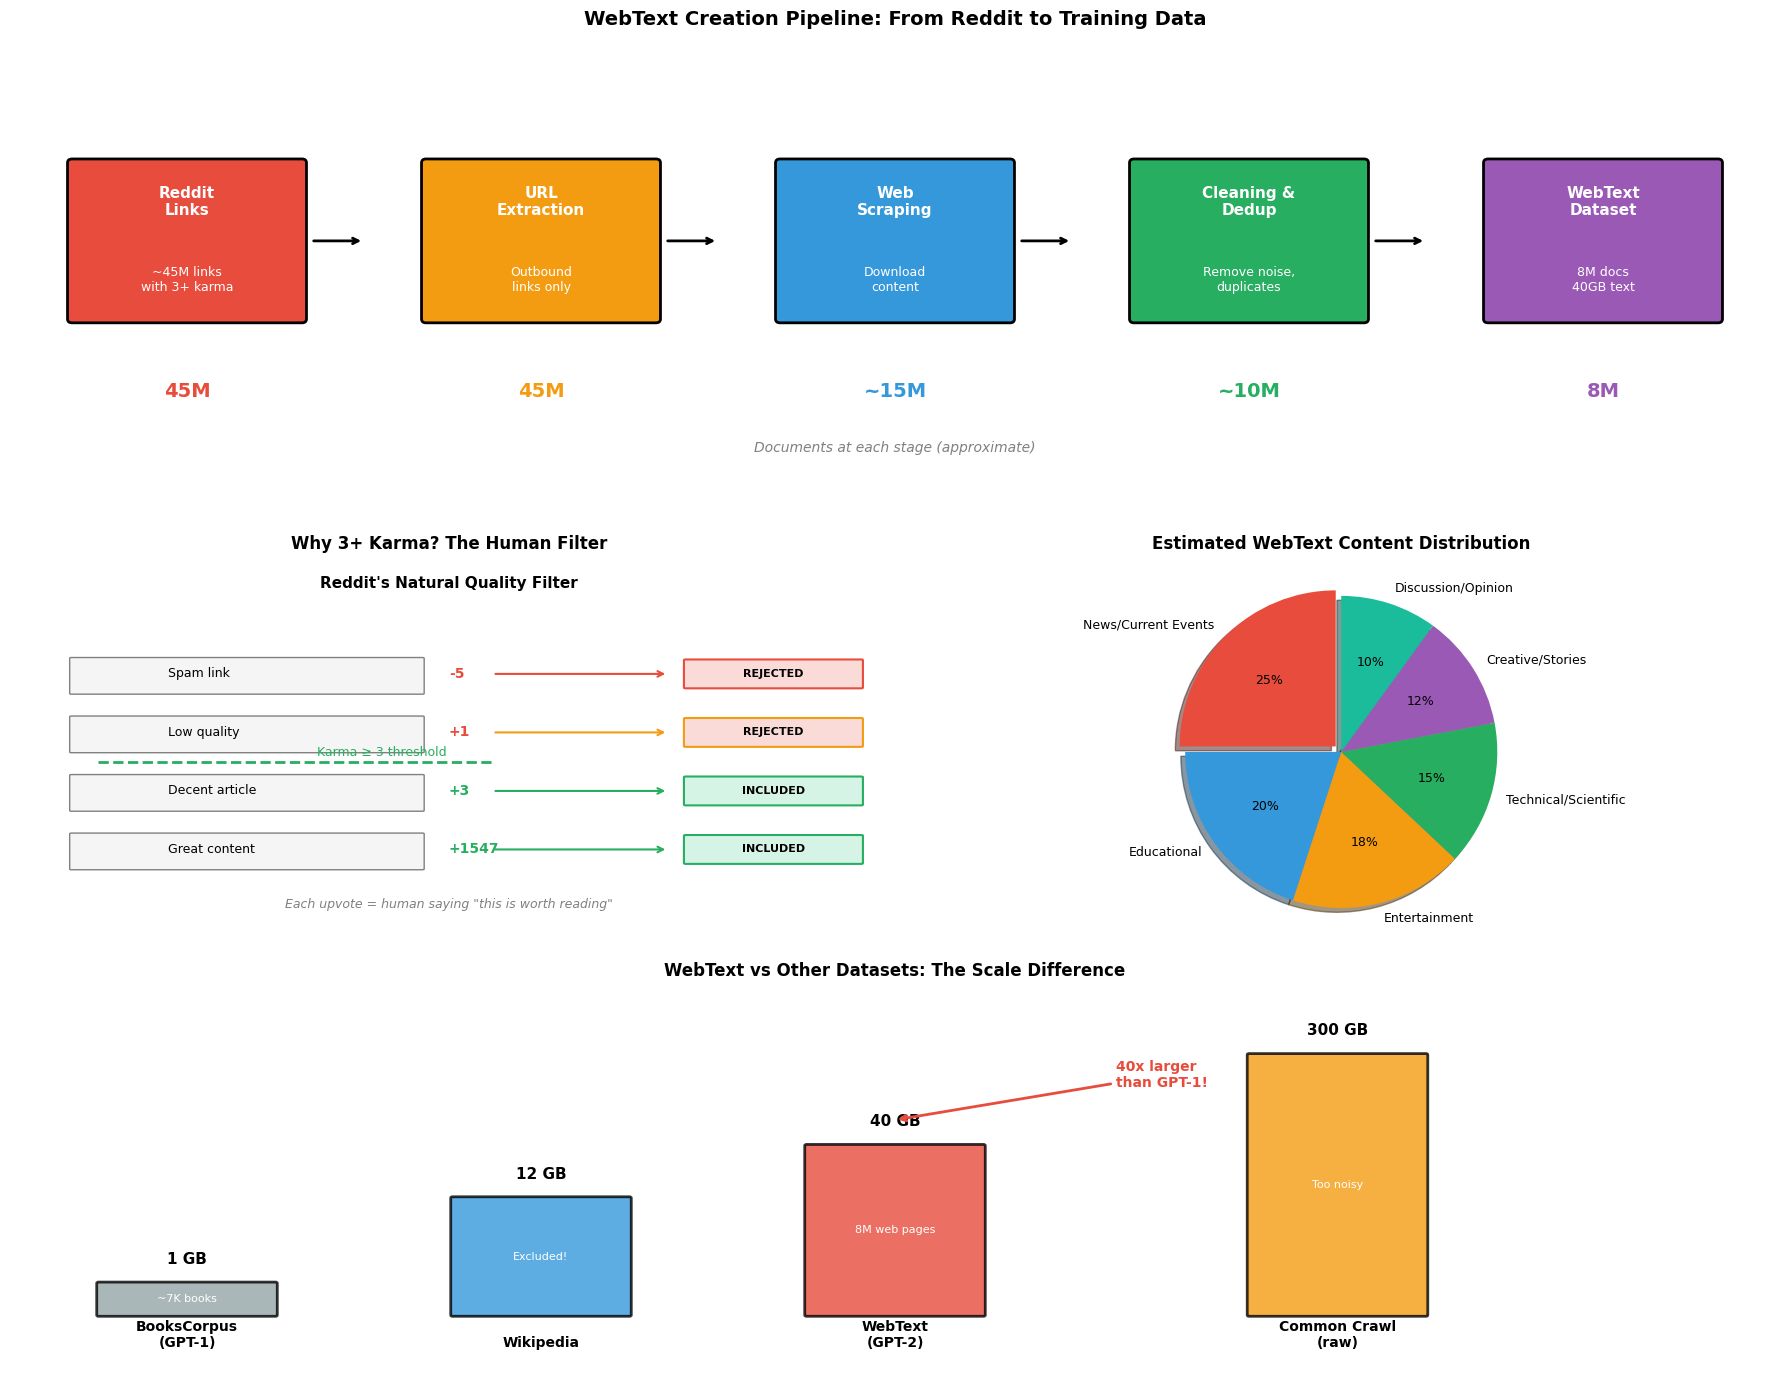

In [3]:
def visualize_webtext_pipeline():
    """
    Detailed visualization of the WebText creation pipeline.
    """
    fig = plt.figure(figsize=(18, 14))

    gs = gridspec.GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    # === TOP: The Full Pipeline ===
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_xlim(0, 20)
    ax1.set_ylim(0, 6)
    ax1.axis('off')
    ax1.set_title('WebText Creation Pipeline: From Reddit to Training Data',
                  fontsize=14, fontweight='bold', pad=15)

    # Pipeline stages
    stages = [
        (2, 'Reddit\nLinks', '~45M links\nwith 3+ karma', '#e74c3c', 'reddit.png'),
        (6, 'URL\nExtraction', 'Outbound\nlinks only', '#f39c12', 'url.png'),
        (10, 'Web\nScraping', 'Download\ncontent', '#3498db', 'download.png'),
        (14, 'Cleaning &\nDedup', 'Remove noise,\nduplicates', '#27ae60', 'clean.png'),
        (18, 'WebText\nDataset', '8M docs\n40GB text', '#9b59b6', 'data.png'),
    ]

    for i, (x, name, desc, color, _) in enumerate(stages):
        # Main box
        rect = FancyBboxPatch((x-1.3, 2.5), 2.6, 2, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x, 4, name, ha='center', va='center', fontsize=11,
                fontweight='bold', color='white')
        ax1.text(x, 3, desc, ha='center', va='center', fontsize=9, color='white')

        # Arrow to next
        if i < len(stages) - 1:
            ax1.annotate('', xy=(x+2, 3.5), xytext=(x+1.4, 3.5),
                        arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # Funnel numbers
    ax1.text(2, 1.5, '45M', fontsize=14, ha='center', fontweight='bold', color='#e74c3c')
    ax1.text(6, 1.5, '45M', fontsize=14, ha='center', fontweight='bold', color='#f39c12')
    ax1.text(10, 1.5, '~15M', fontsize=14, ha='center', fontweight='bold', color='#3498db')
    ax1.text(14, 1.5, '~10M', fontsize=14, ha='center', fontweight='bold', color='#27ae60')
    ax1.text(18, 1.5, '8M', fontsize=14, ha='center', fontweight='bold', color='#9b59b6')

    ax1.text(10, 0.8, 'Documents at each stage (approximate)', ha='center',
             fontsize=10, color='gray', style='italic')

    # === MIDDLE LEFT: The Karma Filter Explanation ===
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('Why 3+ Karma? The Human Filter', fontsize=12, fontweight='bold')

    # Reddit voting visualization
    ax2.text(5, 9.2, 'Reddit\'s Natural Quality Filter', fontsize=11,
             ha='center', fontweight='bold')

    # Post examples
    posts = [
        (1.5, 7, 'Spam link', -5, '#e74c3c', 'REJECTED'),
        (1.5, 5.5, 'Low quality', 1, '#f39c12', 'REJECTED'),
        (1.5, 4, 'Decent article', 3, '#27ae60', 'INCLUDED'),
        (1.5, 2.5, 'Great content', 1547, '#27ae60', 'INCLUDED'),
    ]

    for x, y, label, karma, color, status in posts:
        # Post box
        rect = FancyBboxPatch((x-0.8, y-0.5), 4, 0.9, boxstyle="round,pad=0.02",
                              facecolor='#f5f5f5', edgecolor='gray', linewidth=1)
        ax2.add_patch(rect)
        ax2.text(x+0.3, y, label, fontsize=9, va='center')

        # Karma
        karma_color = '#e74c3c' if karma < 3 else '#27ae60'
        ax2.text(x+3.5, y, f'{karma:+d}', fontsize=10, va='center',
                fontweight='bold', color=karma_color)

        # Arrow and status
        ax2.annotate('', xy=(7.5, y), xytext=(5.5, y),
                    arrowprops=dict(arrowstyle='->', color=color, lw=1.5))

        status_color = '#d5f4e6' if status == 'INCLUDED' else '#fadbd8'
        rect2 = FancyBboxPatch((7.7, y-0.35), 2, 0.7, boxstyle="round,pad=0.02",
                               facecolor=status_color, edgecolor=color, linewidth=1.5)
        ax2.add_patch(rect2)
        ax2.text(8.7, y, status, fontsize=8, ha='center', va='center', fontweight='bold')

    # Threshold line
    ax2.axhline(y=4.75, xmin=0.1, xmax=0.55, color='#27ae60', linestyle='--', linewidth=2)
    ax2.text(3.5, 4.9, 'Karma ≥ 3 threshold', fontsize=9, color='#27ae60')

    ax2.text(5, 1, 'Each upvote = human saying "this is worth reading"',
             ha='center', fontsize=9, color='gray', style='italic')

    # === MIDDLE RIGHT: Content Distribution ===
    ax3 = fig.add_subplot(gs[1, 1])

    # Estimated content distribution in WebText
    categories = ['News/Current Events', 'Educational', 'Entertainment',
                  'Technical/Scientific', 'Creative/Stories', 'Discussion/Opinion']
    sizes = [25, 20, 18, 15, 12, 10]  # Estimated percentages
    colors = ['#e74c3c', '#3498db', '#f39c12', '#27ae60', '#9b59b6', '#1abc9c']
    explode = (0.05, 0, 0, 0, 0, 0)

    wedges, texts, autotexts = ax3.pie(sizes, explode=explode, labels=categories,
                                        colors=colors, autopct='%1.0f%%',
                                        shadow=True, startangle=90,
                                        textprops={'fontsize': 9})
    ax3.set_title('Estimated WebText Content Distribution', fontsize=12, fontweight='bold')

    # === BOTTOM: The Numbers ===
    ax4 = fig.add_subplot(gs[2, :])
    ax4.set_xlim(0, 20)
    ax4.set_ylim(0, 6)
    ax4.axis('off')
    ax4.set_title('WebText vs Other Datasets: The Scale Difference',
                  fontsize=12, fontweight='bold', pad=10)

    # Dataset comparison
    datasets = [
        ('BooksCorpus\n(GPT-1)', 1, '#95a5a6', '~7K books'),
        ('Wikipedia', 12, '#3498db', 'Excluded!'),
        ('WebText\n(GPT-2)', 40, '#e74c3c', '8M web pages'),
        ('Common Crawl\n(raw)', 300, '#f39c12', 'Too noisy'),
    ]

    x_positions = [2, 6, 10, 15]
    max_height = 4
    max_size = 300

    for (name, size, color, note), x in zip(datasets, x_positions):
        # Bar height proportional to log of size
        height = max_height * (np.log10(size + 1) / np.log10(max_size + 1))

        rect = FancyBboxPatch((x-1, 1), 2, height, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=0.8)
        ax4.add_patch(rect)

        ax4.text(x, 0.5, name, ha='center', fontsize=10, fontweight='bold')
        ax4.text(x, 1 + height + 0.3, f'{size} GB', ha='center', fontsize=11, fontweight='bold')
        ax4.text(x, 1 + height/2, note, ha='center', va='center', fontsize=8, color='white')

    # Highlight WebText
    ax4.annotate('40x larger\nthan GPT-1!', xy=(10, 4), xytext=(12.5, 4.5),
                fontsize=10, fontweight='bold', color='#e74c3c',
                arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))

    plt.tight_layout()
    plt.show()

visualize_webtext_pipeline()

---

## 3. Byte-Level BPE: The Tokenization Breakthrough

### 3.1 The Problem with Previous Tokenizers

GPT-1 and most models had a problem:

```
Input: "I love café and naïve résumé"
Old tokenizer: "I love caf[UNK] and na[UNK]ve r[UNK]sum[UNK]"
```

Special characters, emoji, code, and non-English text all became `[UNK]` (unknown).

### 3.2 The GPT-2 Solution: Byte-Level BPE

From the paper:

> *"Byte Pair Encoding (BPE) is a practical middle ground between character and word level language modeling which effectively interpolates between word level inputs for frequent symbol sequences and character level inputs for infrequent symbol sequences."*

> *"A base vocabulary of 256 bytes means that any text can be encoded without any unknown tokens."*

### 3.3 How It Works

1. Start with 256 byte tokens (0-255)
2. Find the most common pair of bytes
3. Merge them into a new token
4. Repeat 50,000 times
5. Result: 50,257 tokens (256 bytes + 50,000 merges + 1 special)

### 3.4 Why 50,257 Exactly?

- 256 base byte tokens
- 50,000 BPE merges
- 1 end-of-text token `<|endoftext|>`
- **Total: 50,257**

### 3.5 The Killer Feature

**No UNK tokens ever.** Any byte sequence can be represented:
- Emoji ✓
- Code ✓
- Any language ✓
- Binary data ✓ (though not useful)

/tmp/ipython-input-1566825852.py:134: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1566825852.py:134: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1566825852.py:134: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1566825852.py:134: UserWarning: Glyph 128512 (\N{GRINNING FACE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans Mono.
  fig.ca

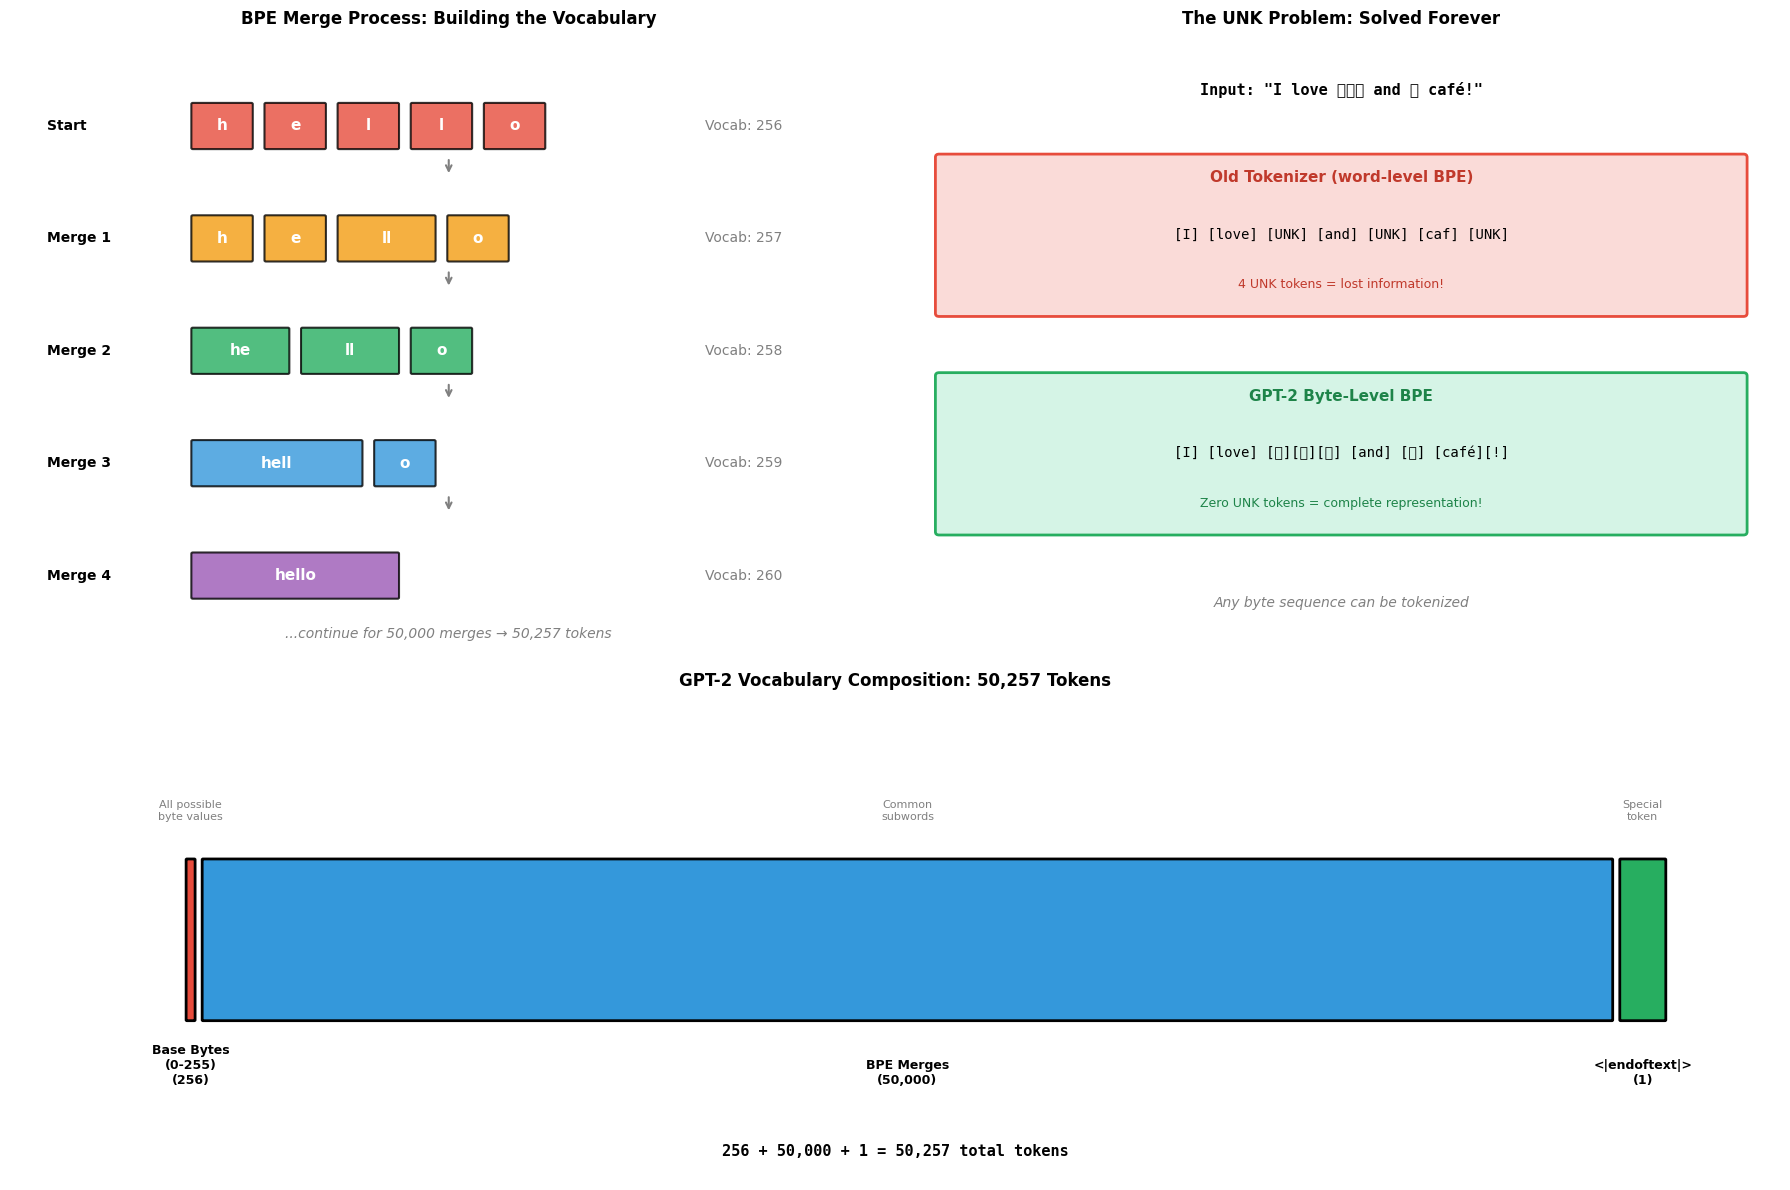

In [4]:
def visualize_byte_level_bpe():
    """
    Visualize how byte-level BPE works and why it's revolutionary.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 2, height_ratios=[1.3, 1])

    # === TOP LEFT: BPE Merge Process ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('BPE Merge Process: Building the Vocabulary',
                  fontsize=12, fontweight='bold')

    # Show merge iterations
    iterations = [
        ('Start', ['h', 'e', 'l', 'l', 'o'], 256, '#e74c3c'),
        ('Merge 1', ['h', 'e', 'll', 'o'], 257, '#f39c12'),
        ('Merge 2', ['he', 'll', 'o'], 258, '#27ae60'),
        ('Merge 3', ['hell', 'o'], 259, '#3498db'),
        ('Merge 4', ['hello'], 260, '#9b59b6'),
    ]

    for i, (stage, tokens, vocab_size, color) in enumerate(iterations):
        y = 8.5 - i * 1.8

        # Stage label
        ax1.text(0.5, y, stage, fontsize=10, fontweight='bold', va='center')

        # Tokens
        x = 2.5
        for tok in tokens:
            width = len(tok) * 0.5 + 0.3
            rect = FancyBboxPatch((x, y-0.35), width, 0.7, boxstyle="round,pad=0.02",
                                  facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.8)
            ax1.add_patch(rect)
            ax1.text(x + width/2, y, tok, ha='center', va='center',
                    fontsize=11, fontweight='bold', color='white')
            x += width + 0.2

        # Vocab size
        ax1.text(9.5, y, f'Vocab: {vocab_size}', fontsize=10, va='center', color='gray')

        # Arrow to next
        if i < len(iterations) - 1:
            ax1.annotate('', xy=(6, y-0.8), xytext=(6, y-0.5),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

    ax1.text(6, 0.3, '...continue for 50,000 merges → 50,257 tokens',
             ha='center', fontsize=10, style='italic', color='gray')

    # === TOP RIGHT: Old vs New Tokenization ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('The UNK Problem: Solved Forever', fontsize=12, fontweight='bold')

    # Input text
    ax2.text(6, 9, 'Input: "I love 日本語 and 😀 café!"',
             ha='center', fontsize=11, family='monospace', fontweight='bold')

    # Old tokenizer
    rect_old = FancyBboxPatch((0.5, 5.5), 11, 2.5, boxstyle="round,pad=0.05",
                               facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax2.add_patch(rect_old)
    ax2.text(6, 7.6, 'Old Tokenizer (word-level BPE)', fontsize=11,
             ha='center', fontweight='bold', color='#c0392b')
    ax2.text(6, 6.7, '[I] [love] [UNK] [and] [UNK] [caf] [UNK]',
             ha='center', fontsize=10, family='monospace')
    ax2.text(6, 5.9, '4 UNK tokens = lost information!',
             ha='center', fontsize=9, color='#c0392b')

    # New tokenizer
    rect_new = FancyBboxPatch((0.5, 2), 11, 2.5, boxstyle="round,pad=0.05",
                               facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect_new)
    ax2.text(6, 4.1, 'GPT-2 Byte-Level BPE', fontsize=11,
             ha='center', fontweight='bold', color='#1e8449')
    ax2.text(6, 3.2, '[I] [love] [日][本][語] [and] [😀] [café][!]',
             ha='center', fontsize=10, family='monospace')
    ax2.text(6, 2.4, 'Zero UNK tokens = complete representation!',
             ha='center', fontsize=9, color='#1e8449')

    ax2.text(6, 0.8, 'Any byte sequence can be tokenized',
             ha='center', fontsize=10, color='gray', style='italic')

    # === BOTTOM: Vocabulary Composition ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 6)
    ax3.axis('off')
    ax3.set_title('GPT-2 Vocabulary Composition: 50,257 Tokens',
                  fontsize=12, fontweight='bold', pad=10)

    # Visual breakdown
    components = [
        (3, 256, 'Base Bytes\n(0-255)', '#e74c3c', 'All possible\nbyte values'),
        (10, 50000, 'BPE Merges', '#3498db', 'Common\nsubwords'),
        (17, 1, '<|endoftext|>', '#27ae60', 'Special\ntoken'),
    ]

    # Draw as stacked representation
    total_width = 16
    start_x = 2

    widths = [256/50257 * total_width, 50000/50257 * total_width, 1/50257 * total_width]
    widths[2] = max(0.3, widths[2])  # Make visible

    x = start_x
    for i, ((_, count, name, color, desc), width) in enumerate(zip(components, widths)):
        if i == 2:  # Special token - use fixed small width but show it
            width = 0.5

        rect = FancyBboxPatch((x, 2), width, 2, boxstyle="round,pad=0.01",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax3.add_patch(rect)

        # Label below
        ax3.text(x + width/2, 1.2, f'{name}\n({count:,})',
                ha='center', fontsize=9, fontweight='bold')

        # Description above
        ax3.text(x + width/2, 4.5, desc, ha='center', fontsize=8, color='gray')

        x += width + 0.1

    # Formula
    ax3.text(10, 0.3, '256 + 50,000 + 1 = 50,257 total tokens',
             ha='center', fontsize=11, fontweight='bold', family='monospace')

    plt.tight_layout()
    plt.show()

visualize_byte_level_bpe()

---

## 4. Zero-Shot: The Mechanism Nobody Explains

### 4.1 How Zero-Shot Actually Works

People say "GPT-2 does zero-shot learning" but don't explain the mechanism.

Here's what actually happens:

### 4.2 The "Natural Demonstrations" Insight

From the paper:

> *"The internet contains a vast amount of information that is passively available without the need for interactive communication... We could in principle train on data where the context contains the task to be performed, expressed in natural language."*

**Key insight:** The internet already contains examples of tasks being performed!

For example, WebText contains:
- "TL;DR: [summary]" after articles
- "Q: ... A: ..." patterns in forums
- "Translate: X means Y in French" in language discussions
- "The answer is..." in educational content

### 4.3 The "Task Demonstration" Discovery

The paper makes a profound observation:

> *"We test GPT-2's ability to perform summarization on the CNN and Daily Mail dataset. To induce summarization behavior we add the text TL;DR: after the article."*

They discovered that **certain tokens act as "task switches"** that activate learned behaviors:

| Token/Pattern | Activated Behavior |
|---------------|--------------------|
| `TL;DR:` | Summarization |
| `Q: ... A:` | Question answering |
| `= ` | Mathematical computation |
| `in French:` | Translation |

### 4.4 Why This Is Profound

The model learned these associations **without being told to**. It discovered:
- What tasks exist
- How to recognize when a task is being requested
- How to perform the task

All from predicting the next word!

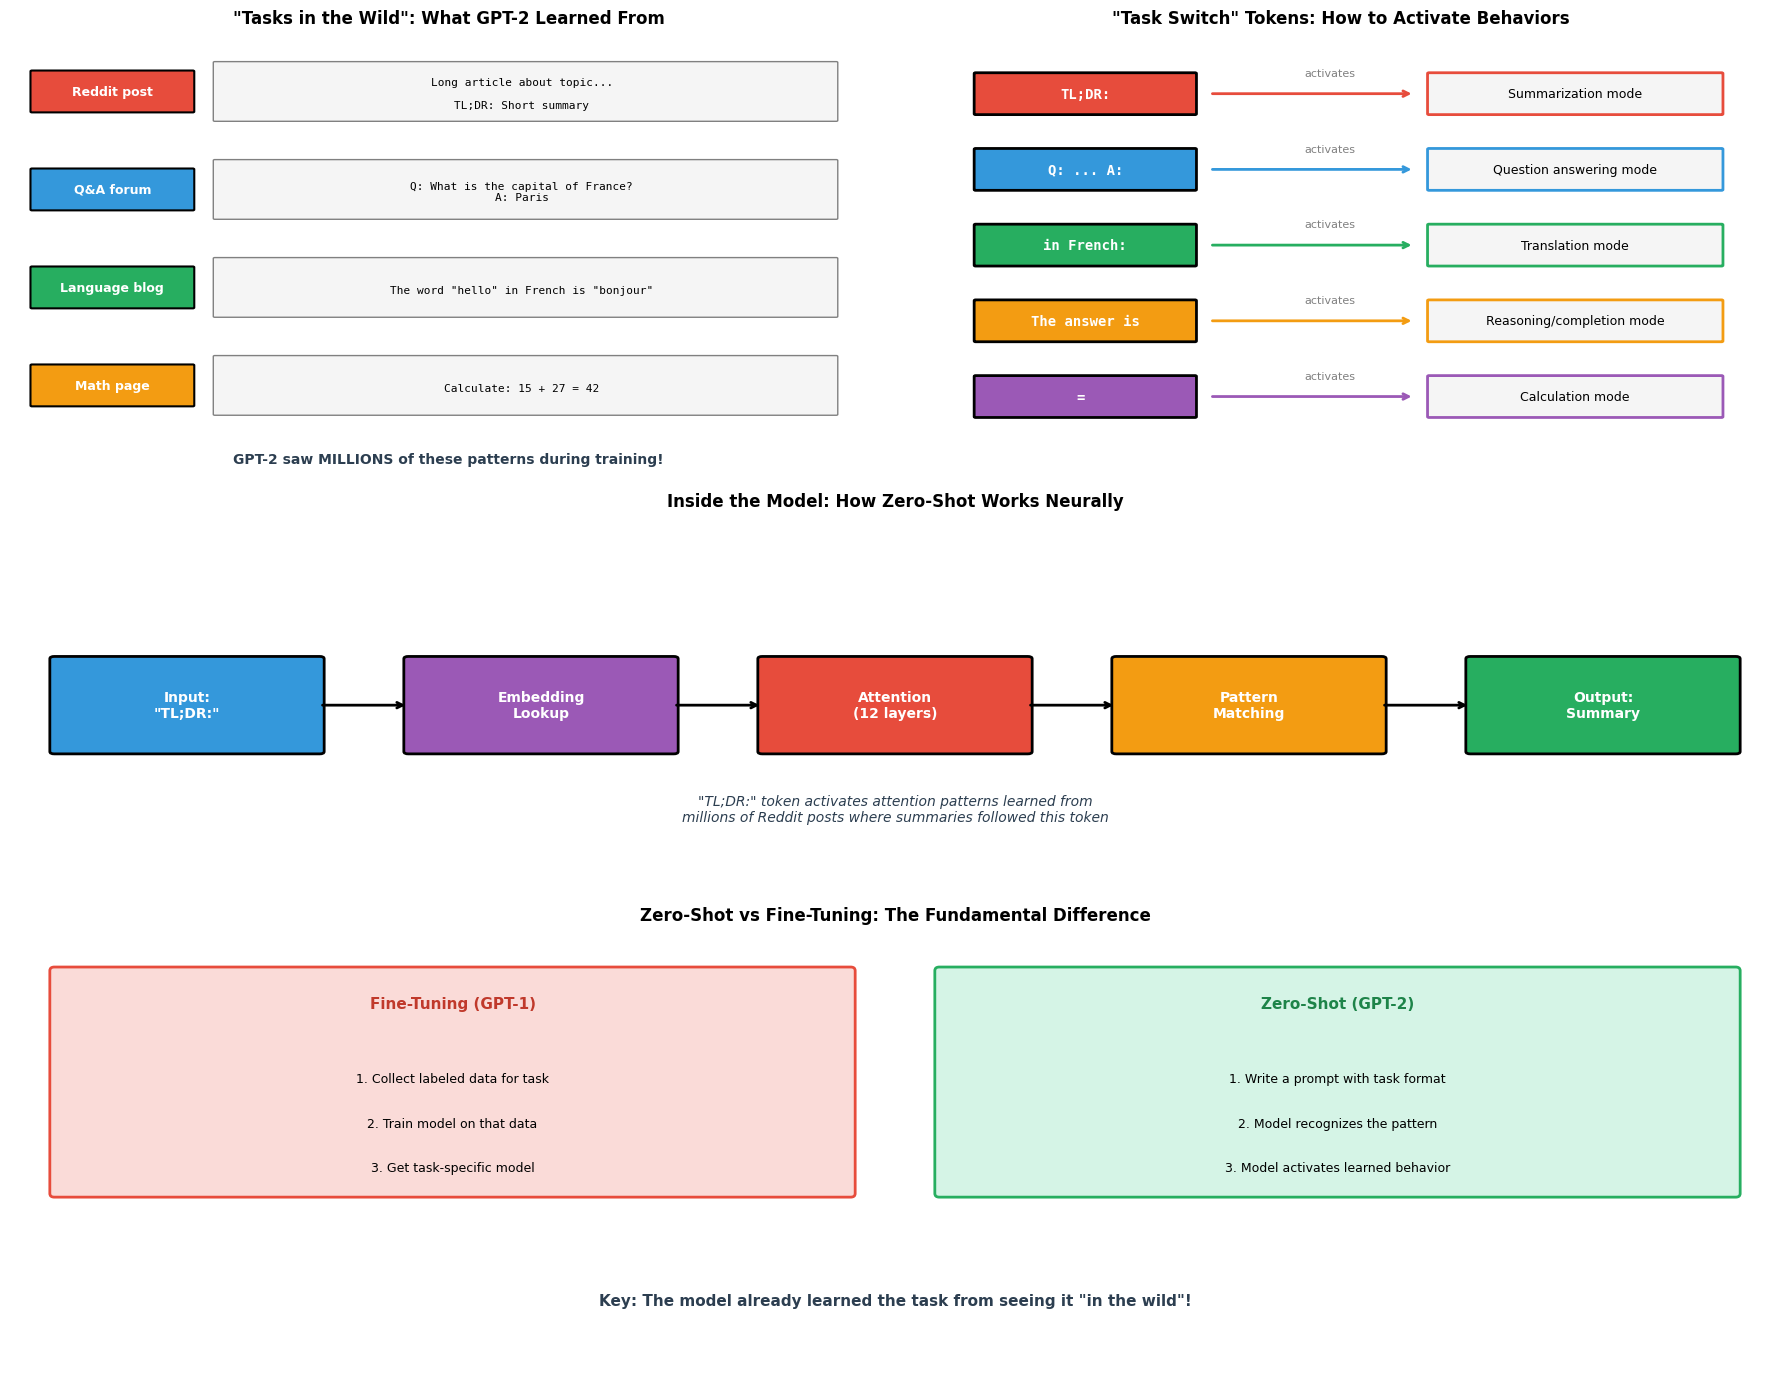

In [5]:
def visualize_zero_shot_mechanism():
    """
    Visualize how zero-shot actually works inside GPT-2.
    """
    fig = plt.figure(figsize=(18, 14))

    gs = gridspec.GridSpec(3, 2, height_ratios=[1.2, 1, 1.2])

    # === TOP LEFT: Tasks in the Wild ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('"Tasks in the Wild": What GPT-2 Learned From',
                  fontsize=12, fontweight='bold')

    # Examples from WebText
    examples = [
        ('Reddit post', 'Long article about topic...\n\nTL;DR: Short summary', '#e74c3c'),
        ('Q&A forum', 'Q: What is the capital of France?\nA: Paris', '#3498db'),
        ('Language blog', 'The word "hello" in French is "bonjour"', '#27ae60'),
        ('Math page', 'Calculate: 15 + 27 = 42', '#f39c12'),
    ]

    for i, (source, text, color) in enumerate(examples):
        y = 8.5 - i * 2.2

        # Source label
        rect_src = FancyBboxPatch((0.3, y-0.3), 2.2, 0.9, boxstyle="round,pad=0.02",
                                   facecolor=color, edgecolor='black', linewidth=1.5)
        ax1.add_patch(rect_src)
        ax1.text(1.4, y + 0.15, source, ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')

        # Text example
        rect_txt = FancyBboxPatch((2.8, y-0.5), 8.5, 1.3, boxstyle="round,pad=0.02",
                                   facecolor='#f5f5f5', edgecolor='gray', linewidth=1)
        ax1.add_patch(rect_txt)
        ax1.text(7, y + 0.1, text, ha='center', va='center',
                fontsize=8, family='monospace')

    ax1.text(6, 0.3, 'GPT-2 saw MILLIONS of these patterns during training!',
             ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

    # === TOP RIGHT: The Task Switch Tokens ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('"Task Switch" Tokens: How to Activate Behaviors',
                  fontsize=12, fontweight='bold')

    switches = [
        ('TL;DR:', 'Summarization mode', '#e74c3c'),
        ('Q: ... A:', 'Question answering mode', '#3498db'),
        ('in French:', 'Translation mode', '#27ae60'),
        ('The answer is', 'Reasoning/completion mode', '#f39c12'),
        ('= ', 'Calculation mode', '#9b59b6'),
    ]

    for i, (token, behavior, color) in enumerate(switches):
        y = 8.5 - i * 1.7

        # Token
        rect = FancyBboxPatch((1, y-0.35), 3, 0.9, boxstyle="round,pad=0.02",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax2.add_patch(rect)
        ax2.text(2.5, y + 0.1, token, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white', family='monospace')

        # Arrow
        ax2.annotate('', xy=(7, y + 0.1), xytext=(4.2, y + 0.1),
                    arrowprops=dict(arrowstyle='->', color=color, lw=2))
        ax2.text(5.5, y + 0.5, 'activates', fontsize=8, color='gray')

        # Behavior
        rect2 = FancyBboxPatch((7.2, y-0.35), 4, 0.9, boxstyle="round,pad=0.02",
                               facecolor='#f5f5f5', edgecolor=color, linewidth=2)
        ax2.add_patch(rect2)
        ax2.text(9.2, y + 0.1, behavior, ha='center', va='center', fontsize=9)

    # === MIDDLE: The Neural Mechanism ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 8)
    ax3.axis('off')
    ax3.set_title('Inside the Model: How Zero-Shot Works Neurally',
                  fontsize=12, fontweight='bold', pad=10)

    # Input -> Embedding -> Attention -> Output
    stages = [
        (2, 'Input:\n"TL;DR:"', '#3498db'),
        (6, 'Embedding\nLookup', '#9b59b6'),
        (10, 'Attention\n(12 layers)', '#e74c3c'),
        (14, 'Pattern\nMatching', '#f39c12'),
        (18, 'Output:\nSummary', '#27ae60'),
    ]

    for x, label, color in stages:
        rect = FancyBboxPatch((x-1.5, 3), 3, 2, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2)
        ax3.add_patch(rect)
        ax3.text(x, 4, label, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')

    # Arrows
    for i in range(len(stages) - 1):
        x1 = stages[i][0] + 1.5
        x2 = stages[i+1][0] - 1.5
        ax3.annotate('', xy=(x2, 4), xytext=(x1, 4),
                    arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # Explanation below
    ax3.text(10, 1.5, '"TL;DR:" token activates attention patterns learned from\n'
             'millions of Reddit posts where summaries followed this token',
             ha='center', fontsize=10, color='#2c3e50', style='italic')

    # === BOTTOM: Comparison ===
    ax4 = fig.add_subplot(gs[2, :])
    ax4.set_xlim(0, 20)
    ax4.set_ylim(0, 6)
    ax4.axis('off')
    ax4.set_title('Zero-Shot vs Fine-Tuning: The Fundamental Difference',
                  fontsize=12, fontweight='bold', pad=10)

    # Fine-tuning (old way)
    rect_ft = FancyBboxPatch((0.5, 2.5), 9, 3, boxstyle="round,pad=0.05",
                              facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax4.add_patch(rect_ft)
    ax4.text(5, 5, 'Fine-Tuning (GPT-1)', fontsize=11, fontweight='bold',
             ha='center', color='#c0392b')
    ax4.text(5, 4, '1. Collect labeled data for task', fontsize=9, ha='center')
    ax4.text(5, 3.4, '2. Train model on that data', fontsize=9, ha='center')
    ax4.text(5, 2.8, '3. Get task-specific model', fontsize=9, ha='center')

    # Zero-shot (new way)
    rect_zs = FancyBboxPatch((10.5, 2.5), 9, 3, boxstyle="round,pad=0.05",
                              facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax4.add_patch(rect_zs)
    ax4.text(15, 5, 'Zero-Shot (GPT-2)', fontsize=11, fontweight='bold',
             ha='center', color='#1e8449')
    ax4.text(15, 4, '1. Write a prompt with task format', fontsize=9, ha='center')
    ax4.text(15, 3.4, '2. Model recognizes the pattern', fontsize=9, ha='center')
    ax4.text(15, 2.8, '3. Model activates learned behavior', fontsize=9, ha='center')

    # Key insight
    ax4.text(10, 1, 'Key: The model already learned the task from seeing it "in the wild"!',
             ha='center', fontsize=11, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.show()

visualize_zero_shot_mechanism()

---

## 5. The Scaling Revelation

### 5.1 The Hidden Discovery

The paper contains a chart that most people ignore, but it changed AI research forever:

> *"Performance on many NLP tasks continues to improve with increasing model capacity."*

But the REAL discovery was:

> *"Log-log plots of performance vs. model size are remarkably linear."*

### 5.2 What This Means

A "linear log-log plot" means:

$$\text{Performance} \propto (\text{Parameters})^\alpha$$

This is a **power law**. It means:
1. Performance scales predictably with size
2. There's no "plateau" where scaling stops working
3. You can predict future model performance by extrapolation

### 5.3 The Numbers That Launched GPT-3

| Model | Parameters | LAMBADA (acc) |
|-------|------------|---------------|
| GPT-2 Small | 117M | 45.99% |
| GPT-2 Medium | 345M | 55.48% |
| GPT-2 Large | 774M | 60.12% |
| GPT-2 XL | 1.5B | 63.24% |

The pattern was clear: **more parameters = better performance**.

This directly led to GPT-3 (175B) and beyond.

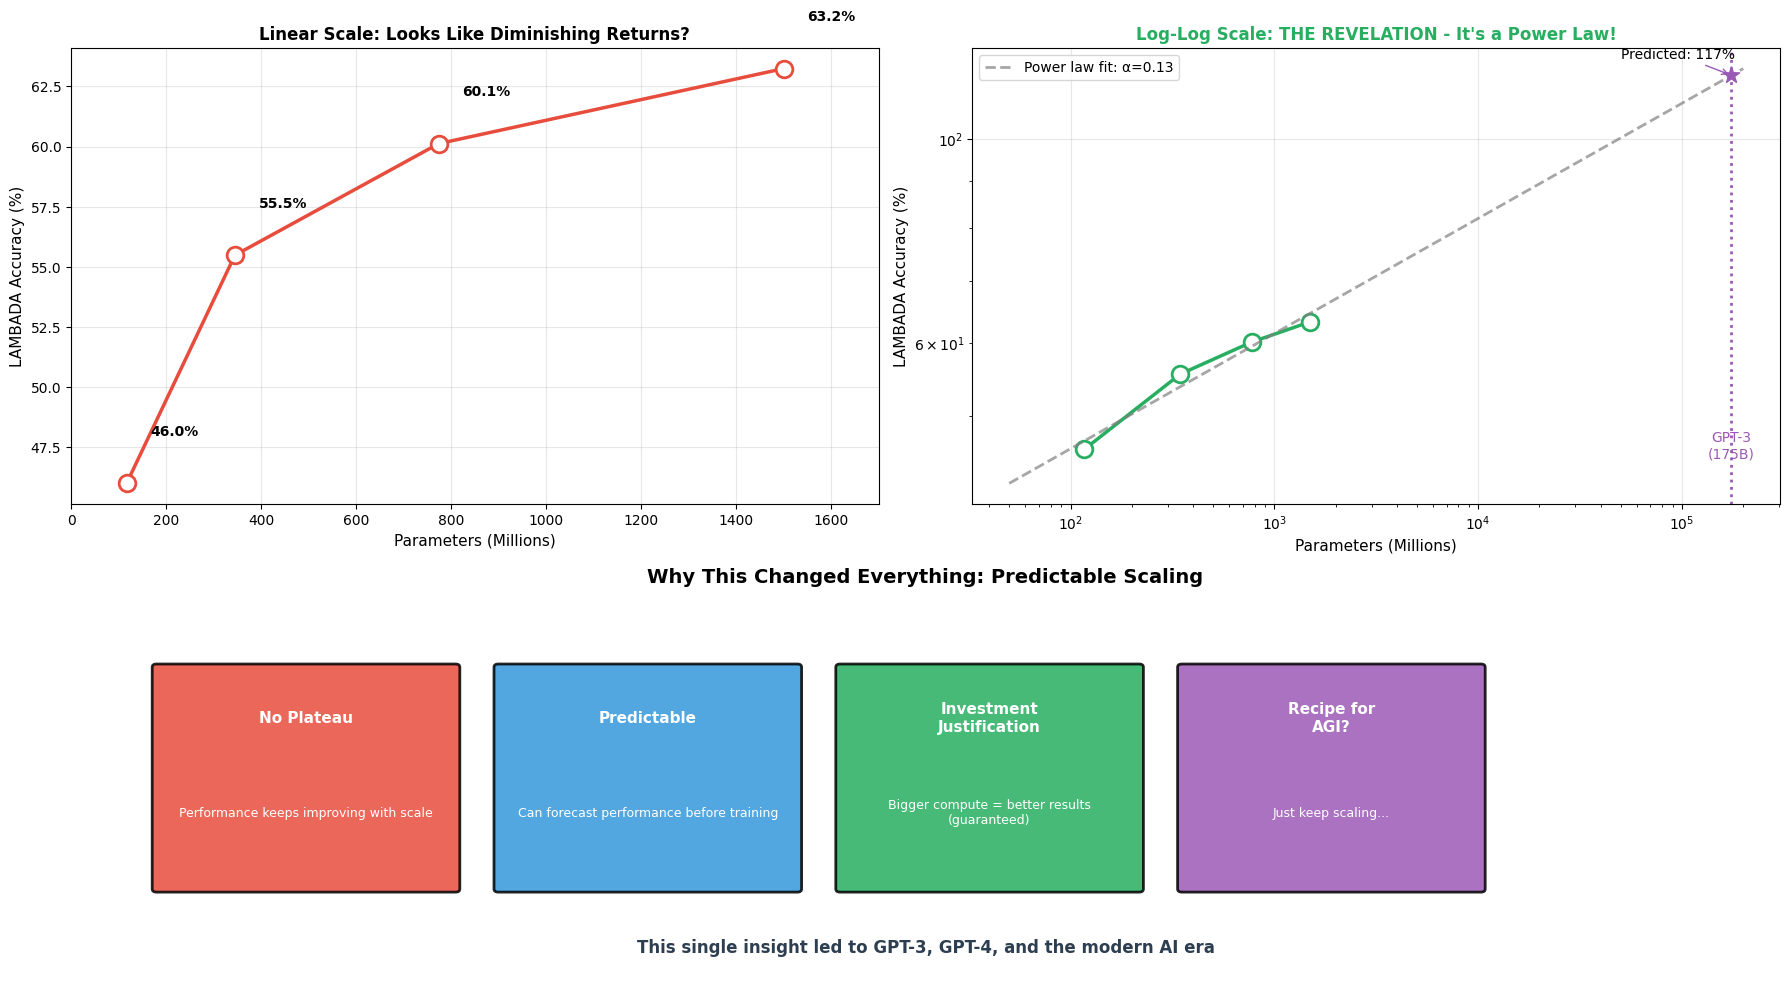

In [6]:
def visualize_scaling_laws():
    """
    Visualize the scaling laws discovery that changed AI.
    """
    fig = plt.figure(figsize=(18, 10))

    gs = gridspec.GridSpec(2, 2, height_ratios=[1.2, 1])

    # === TOP LEFT: Linear plot ===
    ax1 = fig.add_subplot(gs[0, 0])

    params = [117, 345, 774, 1500]  # Millions
    lambada_acc = [45.99, 55.48, 60.12, 63.24]

    ax1.plot(params, lambada_acc, 'o-', color='#e74c3c', linewidth=2.5,
             markersize=12, markerfacecolor='white', markeredgewidth=2)

    for p, acc in zip(params, lambada_acc):
        ax1.annotate(f'{acc:.1f}%', xy=(p, acc), xytext=(p+50, acc+2),
                    fontsize=10, fontweight='bold')

    ax1.set_xlabel('Parameters (Millions)', fontsize=11)
    ax1.set_ylabel('LAMBADA Accuracy (%)', fontsize=11)
    ax1.set_title('Linear Scale: Looks Like Diminishing Returns?',
                  fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1700)

    # === TOP RIGHT: Log-log plot ===
    ax2 = fig.add_subplot(gs[0, 1])

    ax2.loglog(params, lambada_acc, 'o-', color='#27ae60', linewidth=2.5,
               markersize=12, markerfacecolor='white', markeredgewidth=2)

    # Fit line
    log_params = np.log10(params)
    log_acc = np.log10(lambada_acc)
    coeffs = np.polyfit(log_params, log_acc, 1)
    fit_params = np.logspace(np.log10(50), np.log10(200000), 100)
    fit_acc = 10 ** (coeffs[0] * np.log10(fit_params) + coeffs[1])

    ax2.loglog(fit_params, fit_acc, '--', color='gray', linewidth=2, alpha=0.7,
               label=f'Power law fit: α={coeffs[0]:.2f}')

    # Extrapolation to GPT-3
    ax2.axvline(x=175000, color='#9b59b6', linestyle=':', linewidth=2)
    ax2.text(175000, 45, 'GPT-3\n(175B)', fontsize=10, ha='center', color='#9b59b6')

    # Predicted performance
    gpt3_pred = 10 ** (coeffs[0] * np.log10(175000) + coeffs[1])
    ax2.scatter([175000], [gpt3_pred], color='#9b59b6', s=150, marker='*', zorder=5)
    ax2.annotate(f'Predicted: {gpt3_pred:.0f}%', xy=(175000, gpt3_pred),
                xytext=(50000, gpt3_pred+5), fontsize=10,
                arrowprops=dict(arrowstyle='->', color='#9b59b6'))

    ax2.set_xlabel('Parameters (Millions)', fontsize=11)
    ax2.set_ylabel('LAMBADA Accuracy (%)', fontsize=11)
    ax2.set_title('Log-Log Scale: THE REVELATION - It\'s a Power Law!',
                  fontsize=12, fontweight='bold', color='#27ae60')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)

    # === BOTTOM: The Implications ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 6)
    ax3.axis('off')
    ax3.set_title('Why This Changed Everything: Predictable Scaling',
                  fontsize=14, fontweight='bold', pad=15)

    implications = [
        ('No Plateau', 'Performance keeps improving with scale', '#e74c3c'),
        ('Predictable', 'Can forecast performance before training', '#3498db'),
        ('Investment\nJustification', 'Bigger compute = better results\n(guaranteed)', '#27ae60'),
        ('Recipe for\nAGI?', 'Just keep scaling...', '#9b59b6'),
    ]

    for i, (title, desc, color) in enumerate(implications):
        x = 2.5 + i * 4

        rect = FancyBboxPatch((x-1.5, 1.5), 3.5, 3.5, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=0.85)
        ax3.add_patch(rect)

        ax3.text(x + 0.25, 4.2, title, ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')
        ax3.text(x + 0.25, 2.7, desc, ha='center', va='center',
                fontsize=9, color='white')

    ax3.text(10, 0.5, 'This single insight led to GPT-3, GPT-4, and the modern AI era',
             ha='center', fontsize=12, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.show()

visualize_scaling_laws()

---

## 6. The Controversy: Inside the "Too Dangerous" Decision

### 6.1 What Actually Happened

In February 2019, OpenAI released this statement:

> *"Due to our concerns about malicious applications of the technology, we are not releasing the trained model. As an experiment in responsible disclosure, we are instead releasing a much smaller model for researchers to experiment with."*

### 6.2 The Internal Debate

What most people don't know is that this decision was **controversial even within OpenAI**:

**Arguments FOR release:**
- Other groups would replicate it anyway
- Security through obscurity doesn't work
- Researchers need access to study risks
- The model wasn't actually that dangerous

**Arguments AGAINST release:**
- Lowered barrier for misuse
- Automated disinformation at scale
- No defensive measures ready
- Needed to establish norms

### 6.3 The Staged Release Strategy

OpenAI invented a new approach: **staged release**

| Date | Release | Reasoning |
|------|---------|----------|
| Feb 2019 | 117M (Small) | "See what happens" |
| May 2019 | 345M (Medium) | "No major misuse observed" |
| Aug 2019 | 774M (Large) | "Continued monitoring" |
| Nov 2019 | 1.5B (Full) | "6 months, no significant misuse" |

### 6.4 What They Were Actually Worried About

From OpenAI's blog:

1. **Synthetic propaganda** - Automated fake news generation
2. **Impersonation** - Mimicking someone's writing style
3. **Spam** - Scalable low-quality content
4. **Phishing** - More convincing scams

### 6.5 The Irony

Within months:
- Other groups replicated GPT-2 (Grover, CTRL)
- The "danger" was overhyped
- The publicity made GPT-2 famous
- OpenAI became synonymous with "powerful AI"

Some critics called it a **"publicity stunt."**

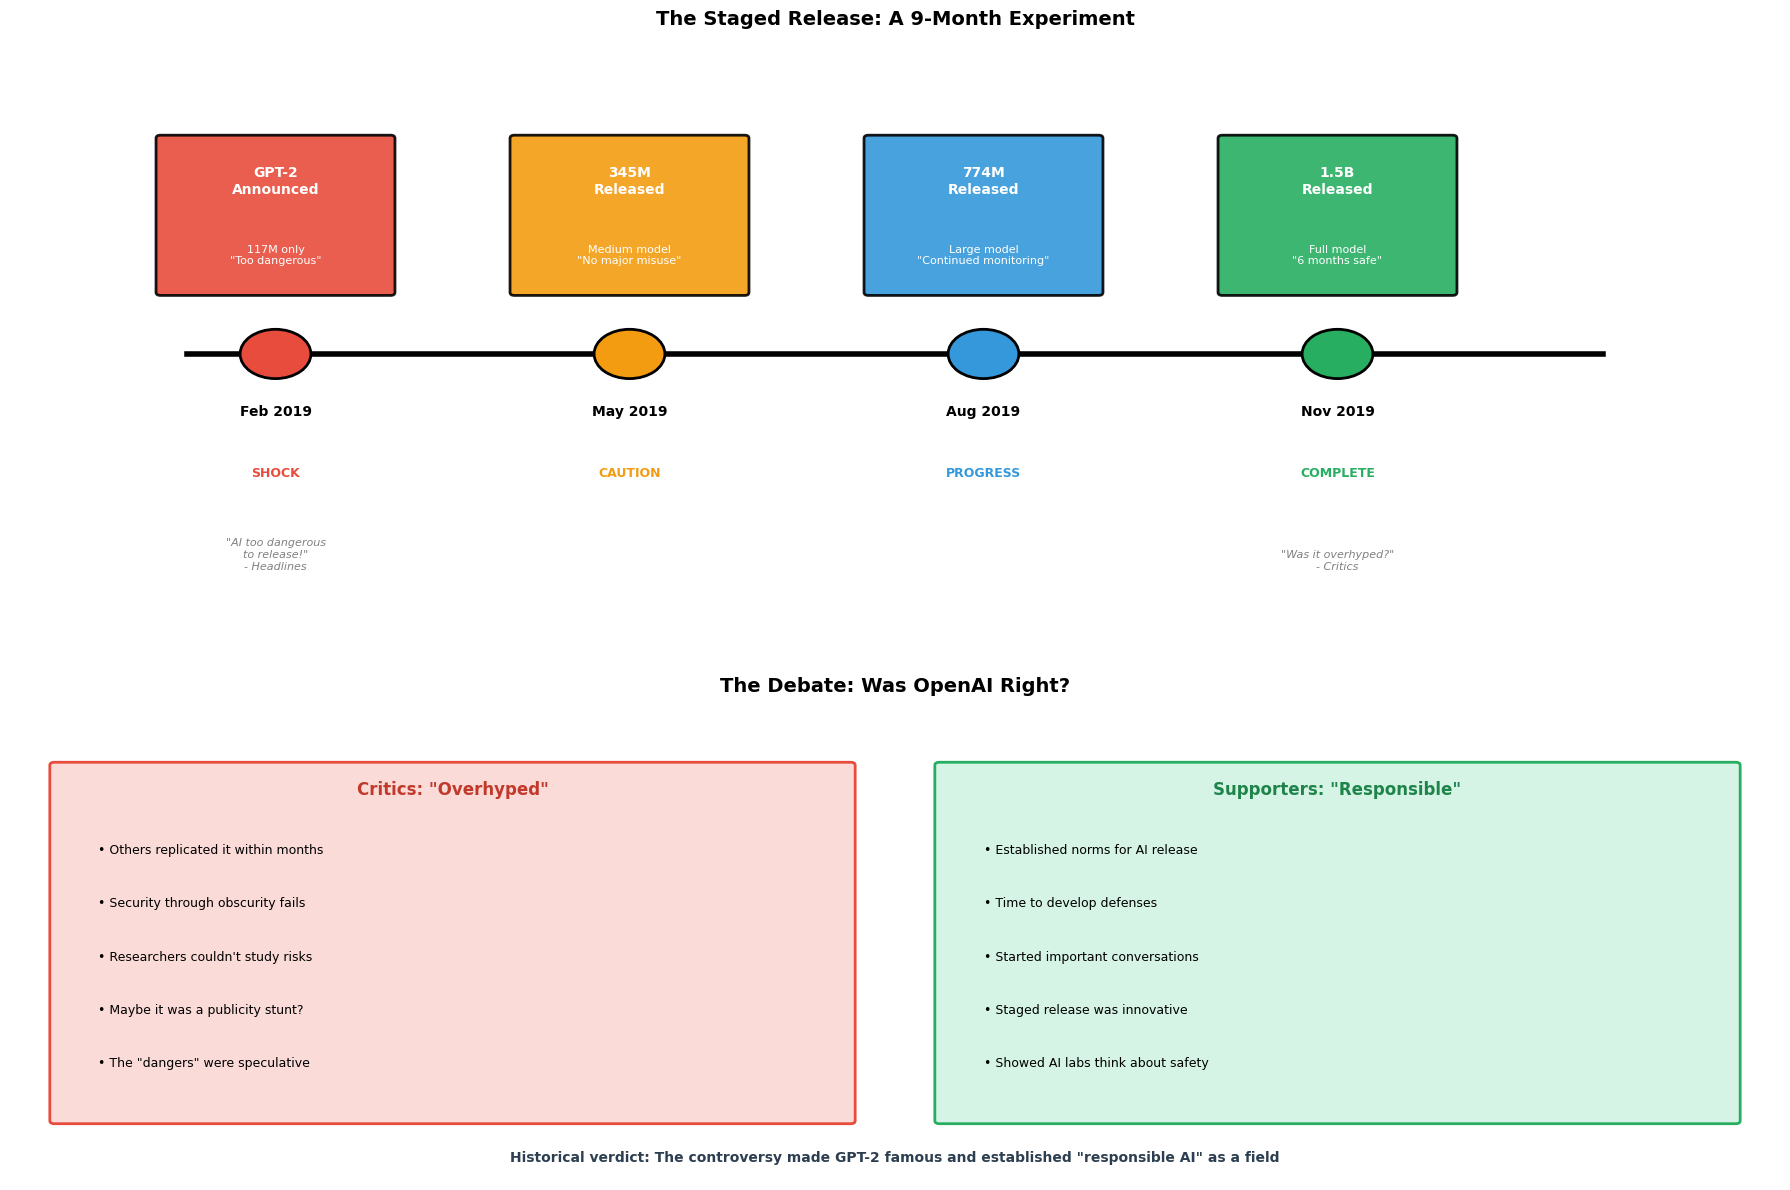

In [7]:
def visualize_the_controversy():
    """
    Visualize the GPT-2 release controversy timeline.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.3, 1])

    # === TOP: Timeline ===
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlim(0, 20)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('The Staged Release: A 9-Month Experiment',
                  fontsize=14, fontweight='bold', pad=15)

    # Timeline
    ax1.plot([2, 18], [5, 5], 'k-', linewidth=4)

    events = [
        (3, 'Feb 2019', 'GPT-2\nAnnounced', '117M only\n"Too dangerous"', '#e74c3c', 'SHOCK'),
        (7, 'May 2019', '345M\nReleased', 'Medium model\n"No major misuse"', '#f39c12', 'CAUTION'),
        (11, 'Aug 2019', '774M\nReleased', 'Large model\n"Continued monitoring"', '#3498db', 'PROGRESS'),
        (15, 'Nov 2019', '1.5B\nReleased', 'Full model\n"6 months safe"', '#27ae60', 'COMPLETE'),
    ]

    for x, date, title, desc, color, status in events:
        # Marker
        circle = plt.Circle((x, 5), 0.4, facecolor=color, edgecolor='black',
                            linewidth=2, zorder=10)
        ax1.add_patch(circle)

        # Date below
        ax1.text(x, 4, date, ha='center', fontsize=10, fontweight='bold')

        # Event box above
        rect = FancyBboxPatch((x-1.3, 6), 2.6, 2.5, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=0.9)
        ax1.add_patch(rect)
        ax1.text(x, 7.8, title, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
        ax1.text(x, 6.6, desc, ha='center', va='center',
                fontsize=8, color='white')

        # Status below
        ax1.text(x, 3, status, ha='center', fontsize=9, color=color, fontweight='bold')

    # Media reactions
    ax1.text(3, 1.5, '"AI too dangerous\nto release!"\n- Headlines',
             ha='center', fontsize=8, color='gray', style='italic')
    ax1.text(15, 1.5, '"Was it overhyped?"\n- Critics',
             ha='center', fontsize=8, color='gray', style='italic')

    # === BOTTOM: The Debate ===
    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(0, 20)
    ax2.set_ylim(0, 8)
    ax2.axis('off')
    ax2.set_title('The Debate: Was OpenAI Right?', fontsize=14, fontweight='bold', pad=10)

    # For release
    rect_for = FancyBboxPatch((0.5, 1), 9, 6, boxstyle="round,pad=0.05",
                               facecolor='#fadbd8', edgecolor='#e74c3c', linewidth=2)
    ax2.add_patch(rect_for)
    ax2.text(5, 6.5, 'Critics: "Overhyped"', fontsize=12, fontweight='bold',
             ha='center', color='#c0392b')

    critics = [
        '• Others replicated it within months',
        '• Security through obscurity fails',
        '• Researchers couldn\'t study risks',
        '• Maybe it was a publicity stunt?',
        '• The "dangers" were speculative',
    ]
    for i, point in enumerate(critics):
        ax2.text(1, 5.5 - i * 0.9, point, fontsize=9)

    # Against release
    rect_against = FancyBboxPatch((10.5, 1), 9, 6, boxstyle="round,pad=0.05",
                                   facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2)
    ax2.add_patch(rect_against)
    ax2.text(15, 6.5, 'Supporters: "Responsible"', fontsize=12, fontweight='bold',
             ha='center', color='#1e8449')

    supporters = [
        '• Established norms for AI release',
        '• Time to develop defenses',
        '• Started important conversations',
        '• Staged release was innovative',
        '• Showed AI labs think about safety',
    ]
    for i, point in enumerate(supporters):
        ax2.text(11, 5.5 - i * 0.9, point, fontsize=9)

    # Verdict
    ax2.text(10, 0.3, 'Historical verdict: The controversy made GPT-2 famous and established "responsible AI" as a field',
             ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.show()

visualize_the_controversy()

---

## 7. Emergent Abilities: What GPT-2 Could Do (That Surprised Everyone)

### 7.1 Abilities Nobody Expected

The paper discovered that GPT-2 could do things **it was never trained to do**:

| Ability | How Discovered | Example |
|---------|----------------|--------|
| Translation | Testing | "hello in French is → bonjour" |
| Arithmetic | Accident | "15 + 27 = → 42" |
| Code completion | Noticed | Could complete Python snippets |
| Story coherence | Testing | Multi-paragraph consistent narratives |

### 7.2 The LAMBADA Breakthrough

LAMBADA tests whether a model understands **long-range dependencies** in text:

> *"She packed her ___"* requires knowing the context 50+ words back.

Previous best: 51.21% (supervised)
GPT-2 1.5B: **63.24% (zero-shot!)**

### 7.3 The Children's Book Test

Tests whether models understand named entities in stories:

> Previous SOTA: 85.8%
> GPT-2 1.5B: **93.3%**

### 7.4 What This Means

These "emergent abilities" suggested that:
1. Language models learn more than just word prediction
2. Understanding appears at sufficient scale
3. Tasks "emerge" without being explicitly taught

This concept of **emergent abilities** would become central to AI research.

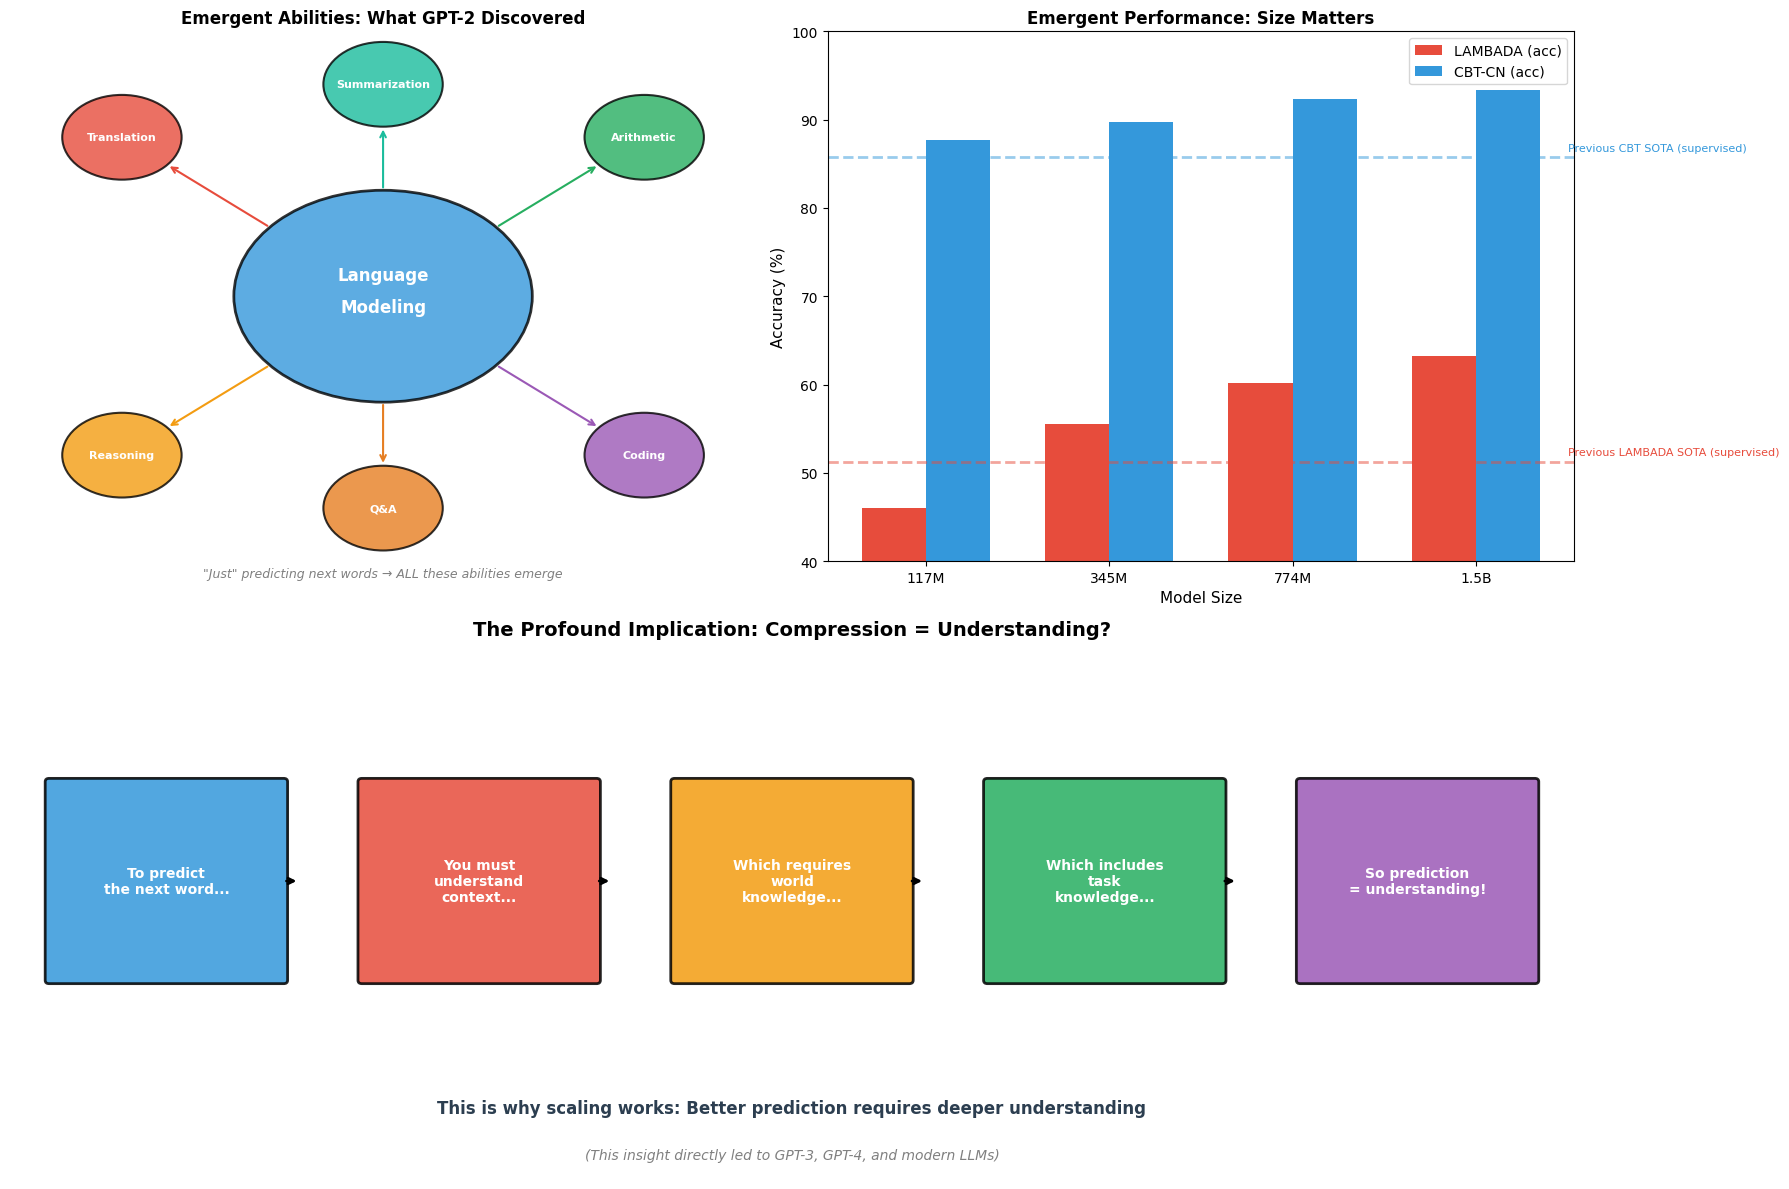

In [8]:
def visualize_emergent_abilities():
    """
    Visualize the emergent abilities discovered in GPT-2.
    """
    fig = plt.figure(figsize=(18, 12))

    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # === TOP LEFT: What is emergence? ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('Emergent Abilities: What GPT-2 Discovered',
                  fontsize=12, fontweight='bold')

    # Central concept
    circle = plt.Circle((5, 5), 2, facecolor='#3498db', edgecolor='black',
                        linewidth=2, alpha=0.8)
    ax1.add_patch(circle)
    ax1.text(5, 5.3, 'Language', ha='center', fontsize=12, fontweight='bold', color='white')
    ax1.text(5, 4.7, 'Modeling', ha='center', fontsize=12, fontweight='bold', color='white')

    # Emergent abilities
    abilities = [
        (1.5, 8, 'Translation', '#e74c3c'),
        (8.5, 8, 'Arithmetic', '#27ae60'),
        (1.5, 2, 'Reasoning', '#f39c12'),
        (8.5, 2, 'Coding', '#9b59b6'),
        (5, 9, 'Summarization', '#1abc9c'),
        (5, 1, 'Q&A', '#e67e22'),
    ]

    for x, y, name, color in abilities:
        # Small circle
        circ = plt.Circle((x, y), 0.8, facecolor=color, edgecolor='black',
                          linewidth=1.5, alpha=0.8)
        ax1.add_patch(circ)
        ax1.text(x, y, name, ha='center', va='center', fontsize=8,
                fontweight='bold', color='white')

        # Arrow from center
        dx = x - 5
        dy = y - 5
        length = np.sqrt(dx**2 + dy**2)
        ax1.annotate('', xy=(x - 0.8*dx/length, y - 0.8*dy/length),
                    xytext=(5 + 2*dx/length, 5 + 2*dy/length),
                    arrowprops=dict(arrowstyle='->', color=color, lw=1.5))

    ax1.text(5, -0.3, '"Just" predicting next words → ALL these abilities emerge',
             ha='center', fontsize=9, color='gray', style='italic')

    # === TOP RIGHT: Performance by size ===
    ax2 = fig.add_subplot(gs[0, 1])

    # Data
    sizes = ['117M', '345M', '774M', '1.5B']
    x_pos = np.arange(len(sizes))

    lambada = [45.99, 55.48, 60.12, 63.24]
    cbt = [87.65, 89.77, 92.35, 93.30]

    width = 0.35
    ax2.bar(x_pos - width/2, lambada, width, label='LAMBADA (acc)', color='#e74c3c')
    ax2.bar(x_pos + width/2, cbt, width, label='CBT-CN (acc)', color='#3498db')

    ax2.set_xlabel('Model Size', fontsize=11)
    ax2.set_ylabel('Accuracy (%)', fontsize=11)
    ax2.set_title('Emergent Performance: Size Matters', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sizes)
    ax2.legend(fontsize=10)
    ax2.set_ylim(40, 100)

    # Previous SOTA lines
    ax2.axhline(y=51.21, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)
    ax2.axhline(y=85.8, color='#3498db', linestyle='--', alpha=0.5, linewidth=2)
    ax2.text(3.5, 52, 'Previous LAMBADA SOTA (supervised)', fontsize=8, color='#e74c3c')
    ax2.text(3.5, 86.5, 'Previous CBT SOTA (supervised)', fontsize=8, color='#3498db')

    # === BOTTOM: The profound implication ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.set_xlim(0, 20)
    ax3.set_ylim(0, 8)
    ax3.axis('off')
    ax3.set_title('The Profound Implication: Compression = Understanding?',
                  fontsize=14, fontweight='bold', pad=10)

    # The chain of reasoning
    steps = [
        (2, 'To predict\nthe next word...', '#3498db'),
        (6, 'You must\nunderstand\ncontext...', '#e74c3c'),
        (10, 'Which requires\nworld\nknowledge...', '#f39c12'),
        (14, 'Which includes\ntask\nknowledge...', '#27ae60'),
        (18, 'So prediction\n= understanding!', '#9b59b6'),
    ]

    for i, (x, text, color) in enumerate(steps):
        rect = FancyBboxPatch((x-1.5, 3), 3, 3, boxstyle="round,pad=0.05",
                              facecolor=color, edgecolor='black', linewidth=2, alpha=0.85)
        ax3.add_patch(rect)
        ax3.text(x, 4.5, text, ha='center', va='center', fontsize=10,
                fontweight='bold', color='white')

        if i < len(steps) - 1:
            ax3.annotate('', xy=(x+1.7, 4.5), xytext=(x+1.5, 4.5),
                        arrowprops=dict(arrowstyle='->', color='black', lw=2))

    ax3.text(10, 1, 'This is why scaling works: Better prediction requires deeper understanding',
             ha='center', fontsize=12, fontweight='bold', color='#2c3e50')
    ax3.text(10, 0.3, '(This insight directly led to GPT-3, GPT-4, and modern LLMs)',
             ha='center', fontsize=10, color='gray', style='italic')

    plt.tight_layout()
    plt.show()

visualize_emergent_abilities()

---

## 8. Summary: The Complete Picture

### 8.1 What GPT-2 Really Was

GPT-2 wasn't just a bigger language model. It was:

1. **A hypothesis test** - Can language modeling learn all tasks?
2. **A scaling experiment** - What happens with 10x more data and parameters?
3. **A safety experiment** - What are the risks of powerful AI?
4. **A paradigm shift** - From fine-tuning to zero-shot

### 8.2 The Legacy

| Discovery | Impact |
|-----------|--------|
| Zero-shot works | Led to GPT-3's in-context learning |
| Scaling laws | Justified billions in compute investment |
| WebText approach | Common Crawl → cleaned web data |
| Staged release | Standard practice for AI releases |
| Emergent abilities | Central research topic today |

### 8.3 The Path Forward

GPT-2 asked: "What if we scale?"

The answer led to:
- GPT-3 (175B) - Proved in-context learning
- GPT-4 - Multimodal + even larger
- ChatGPT - RLHF made it conversational
- The entire modern LLM ecosystem

---

### What's Next: Part II - Architecture Details

We'll cover:
- Pre-LN vs Post-LN (the critical change)
- Scaled initialization (1/√N)
- All four model sizes
- Complete implementation

---

## References

1. Radford et al. (2019). [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
2. OpenAI Blog (2019). [Better Language Models and Their Implications](https://openai.com/blog/better-language-models/)
3. Kaplan et al. (2020). [Scaling Laws for Neural Language Models](https://arxiv.org/abs/2001.08361)
4. McCann et al. (2018). [The Natural Language Decathlon](https://arxiv.org/abs/1806.08730)